# INSY 670: Social Media Analytics - Group Project

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import gensim
import gensim.corpora as corpora
import nltk
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from rich import print

# %load_ext cudf.pandas
%load_ext rich
%load_ext autoreload
%autoreload 2


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

nltk.download("stopwords")
pd.set_option("display.max_columns", None)
pyLDAvis.enable_notebook()
tqdm.pandas()

os.makedirs("./data", exist_ok=True)
os.makedirs("./graphs", exist_ok=True)

[nltk_data] Downloading package stopwords to C:\Users\Lakshya
[nltk_data]     Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
SUBREDDIT_NAME = "FortNiteBR"
TIME_THRESHOLD = pd.Timestamp('2023-06-01 00:00:00')

### Submissions

In [3]:
SUBMISSIONS_DIR = "./data/reddit/processed/submissions/"
SUBMISSIONS_FILES = os.listdir(SUBMISSIONS_DIR)

SUBMISSIONS_IDS = sorted([int(x.split("_")[1]) for x in SUBMISSIONS_FILES])

submissions = []

for file_id in SUBMISSIONS_IDS[::-1]:
    x = pd.read_csv(f"{SUBMISSIONS_DIR}{SUBREDDIT_NAME}_{file_id}_submissions.csv")
    earliest_date = pd.to_datetime(x["created_utc"], unit="s").min()

    submissions.append(x)

    if earliest_date <= TIME_THRESHOLD:
        print(f"Threshold reached at {file_id}")
        break

submissions = pd.concat(submissions)

Threshold reached at 62

In [4]:
submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups
0,Techa,1.701671e+09,self.FortNiteBR,18ae882,True,5,1,I know I claimed the rewards for getting the f...,FortNiteBR,t5_3oeyf,3311984,I got to level 58 but it gave me extra rewards...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0
1,ParsleyVegetable2191,1.701671e+09,self.FortNiteBR,18ae89d,True,0,3,Join Gremlin3333836 on twitch to see your Lego...,FortNiteBR,t5_3oeyf,3311985,Fornite Lego skins,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,3.0
2,dicetrain,1.701671e+09,i.redd.it,18ae8d0,False,3,7,IMO Cozy Jonesy has held the throne for a long...,FortNiteBR,t5_3oeyf,3311986,Best Jonesy ever?,https://i.redd.it/59b7u3r2284c1.jpeg,0.0,7.0
3,EvAnZeGeek,1.701671e+09,self.FortNiteBR,18ae8f6,True,0,1,I recently came back to the game and discovere...,FortNiteBR,t5_3oeyf,3311990,Items in locker are missing,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0
4,The_King123431,1.701671e+09,self.FortNiteBR,18ae8he,True,2,1,I launched the game and accepted all the free ...,FortNiteBR,t5_3oeyf,3311990,Did anyone else not get the vbucks from the ro...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36365,Weekly_Extreme_8881,1.685872e+09,shrinke.me,1407y0w,False,0,1,NaN,FortNiteBR,t5_3oeyf,2527697,Guys!!!!check out my crazy video pls like and ...,https://shrinke.me/DCaOTi,0.0,1.0
36366,Classyninjakid31,1.685872e+09,self.FortNiteBR,1407zel,True,2,0,I’ve seen people say their career leaderboard ...,FortNiteBR,t5_3oeyf,2527697,Career leaderboard,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0
36367,[deleted],1.685873e+09,NaN,14084k4,True,0,0,[deleted],FortNiteBR,t5_3oeyf,2527697,I need your help gamers of Asian servers.,NaN,0.0,0.0
36368,vinsmokewhoswho,1.685873e+09,self.FortNiteBR,14089jo,True,15,0,"First season I actually wanna get the styles, ...",FortNiteBR,t5_3oeyf,2527697,"185 rn, still possible to get to 200?",https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0


### Comments

In [5]:
COMMENTS_DIR = "./data/reddit/processed/comments/"
COMMENTS_FILES = os.listdir(COMMENTS_DIR)

COMMENTS_IDS = sorted([int(x.split("_")[1]) for x in COMMENTS_FILES])

comments = []

for file_id in COMMENTS_IDS[::-1]:
  x = pd.read_csv(f'{COMMENTS_DIR}{SUBREDDIT_NAME}_{file_id}_comments.csv')
  earliest_date = pd.to_datetime(x['created_utc'], unit='s').min()

  comments.append(x)

  if earliest_date <= TIME_THRESHOLD:
    print(f"Threshold reached at {file_id}")
    break

comments = pd.concat(comments)

Threshold reached at 264

In [6]:
submissions = submissions[~submissions["author"].isin(["[deleted]", "[removed]"])]
comments = comments[~comments["author"].isin(["[deleted]", "[removed]"])]
comments["submission_id"] = comments["link_id"].str.split("t3_").str[1]

In [7]:
comments

,body,name,link_id,parent_id,downs,subreddit,score,ups,author,created_utc,permalink,submission_id
0,C1:S5 Ace. I don’t really main anyone anymore ...,t1_kf1801a,t3_18r8jxr,t3_18r8jxr,0,FortNiteBR,1,1,TheRedDragonCW,1.703624e+09,/r/FortNiteBR/comments/18r8jxr/what_was_your_f...,18r8jxr
1,"I joked with my friend about how ""Jesus is PRO...",t1_kf1802a,t3_18qygsb,t1_kf17vmd,0,FortNiteBR,1,1,itsMagicMaddie,1.703624e+09,/r/FortNiteBR/comments/18qygsb/what_does_your_...,18qygsb
2,I normally play shuffle with a bunch of preset...,t1_kf181gz,t3_18r8l3g,t3_18r8l3g,0,FortNiteBR,1,1,darkdeath174,1.703624e+09,/r/FortNiteBR/comments/18r8l3g/drop_your_main_...,18r8l3g
3,Quite literally yes,t1_kf181my,t3_18io9yb,t1_kdgrbx9,0,FortNiteBR,1,1,Much_Election6247,1.703624e+09,/r/FortNiteBR/comments/18io9yb/this_is_how_i_f...,18io9yb
4,Merry marauder cos I’m matching with my gf. Bu...,t1_kf182gr,t3_18r8l3g,t3_18r8l3g,0,FortNiteBR,1,1,yhavmin,1.703624e+09,/r/FortNiteBR/comments/18r8l3g/drop_your_main_...,18r8l3g
...,...,...,...,...,...,...,...,...,...,...,...,...
67492,Comparison here and there,t1_jnj5ic1,t3_14564y3,t3_14564y3,0,FortNiteBR,1,1,ogg_ogg,1.686320e+09,/r/FortNiteBR/comments/14564y3/literally_the_s...,14564y3
67493,Bro your dumber than a kindergartener\n💀,t1_jnj5ieb,t3_14551we,t1_jnj0n0e,0,FortNiteBR,-34,-34,Ambitious-Growth-627,1.686320e+09,/r/FortNiteBR/comments/14551we/by_the_way_the_...,14551we
67494,I’m hyped up for the new battle pass,t1_jnj5iry,t3_144pkh0,t3_144pkh0,0,FortNiteBR,1,1,SuperSonicRacing534,1.686320e+09,/r/FortNiteBR/comments/144pkh0/fortnite_chapte...,144pkh0
67495,The gorilla tag group they're in really seals ...,t1_jnj5j0m,t3_14565g7,t1_jnj5f63,0,FortNiteBR,9,9,Cheap-Pie8077,1.686320e+09,/r/FortNiteBR/comments/14565g7/my_son_got_bann...,14565g7


## Topic modeling

In [8]:
submissions['year'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.year

C:\Users\Lakshya Agarwal\AppData\Local\Temp\ipykernel_11584\1221592855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions['year'] = pd.to_datetime(submissions['created_utc'], unit='s').dt.year


In [9]:
# Clean submission title
stop_words = stopwords.words("english")
stop_words.extend(["google"])

def clean_post_title(post):
    return " ".join(
        [
            word
            for word in simple_preprocess(post)
            if word not in stop_words and len(word) > 2
        ]
    )

In [10]:
sample = submissions["title"].sample(10, random_state=42).tolist()
print(sample)

sample_cleaned = [clean_post_title(post) for post in sample]
print(sample_cleaned)

[
    'Team Wipe...RIP Trios',
    'I might just be the next Ninja',
    'Will the OG Paradigm skin make a return?',
    'Chat, what if this was real?',
    'Hawaii servers',
    'is the starwars skins gonna stay until tomorrow? i’m gifting it but i have to wait another day to gift it to 
them.',
    "POV: You're going to open vault and see the teammate with no kills already waiting there",
    'Everyone confirms his presence Get ready for #giveawayUSER on Sunday #giveaways #giveawayindonesia 
#giveawayindo #giveawaycontest #Giveawaytime #giveawayolshop #giveaway2023 #giveawayph #giveawayhijab 
#giveawaywithzoi #fortnitememe #fortnitenews #fortnitewin',
    'Junk Junction Got Junked. Fortnite Chapter 1 Elimination Game DAY 2: Vote Out Your Least Favorite Location 
(Link To Vote In Body Text Of Post)',
    'cheaters teaming up against me in solos. \U0001fae4'
]

[
    'team wipe rip trios',
    'might next ninja',
    'paradigm skin make return',
    'chat real',
    'hawaii servers',
    'starwars skins gonna stay tomorrow gifting wait another day gift',
    'pov going open vault see teammate kills already waiting',
    'everyone confirms presence get ready giveawayuser sunday giveaways giveawayindo giveawaycontest giveawaytime 
giveawayolshop giveaway giveawayph giveawayhijab giveawaywithzoi fortnitememe fortnitenews fortnitewin',
    'junk junction got junked fortnite chapter elimination game day vote least favorite location link vote body 
text post',
    'cheaters teaming solos'
]

In [11]:
submissions["clean_title"] = submissions["title"].apply(clean_post_title)

C:\Users\Lakshya Agarwal\AppData\Local\Temp\ipykernel_11584\3177998021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions["clean_title"] = submissions["title"].apply(clean_post_title)


In [12]:
submissions

,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title
0,Techa,1.701671e+09,self.FortNiteBR,18ae882,True,5,1,I know I claimed the rewards for getting the f...,FortNiteBR,t5_3oeyf,3311984,I got to level 58 but it gave me extra rewards...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,got level gave extra rewards
1,ParsleyVegetable2191,1.701671e+09,self.FortNiteBR,18ae89d,True,0,3,Join Gremlin3333836 on twitch to see your Lego...,FortNiteBR,t5_3oeyf,3311985,Fornite Lego skins,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,3.0,2023,fornite lego skins
2,dicetrain,1.701671e+09,i.redd.it,18ae8d0,False,3,7,IMO Cozy Jonesy has held the throne for a long...,FortNiteBR,t5_3oeyf,3311986,Best Jonesy ever?,https://i.redd.it/59b7u3r2284c1.jpeg,0.0,7.0,2023,best jonesy ever
3,EvAnZeGeek,1.701671e+09,self.FortNiteBR,18ae8f6,True,0,1,I recently came back to the game and discovere...,FortNiteBR,t5_3oeyf,3311990,Items in locker are missing,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,items locker missing
4,The_King123431,1.701671e+09,self.FortNiteBR,18ae8he,True,2,1,I launched the game and accepted all the free ...,FortNiteBR,t5_3oeyf,3311990,Did anyone else not get the vbucks from the ro...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,anyone else get vbucks rocket league stuff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,Blue-Gryphon297,1.685871e+09,self.FortNiteBR,1407q4f,True,4,0,I've won maybe two games in the dozens I've pl...,FortNiteBR,t5_3oeyf,2527696,What is with the MMR system lately?,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,mmr system lately
36365,Weekly_Extreme_8881,1.685872e+09,shrinke.me,1407y0w,False,0,1,NaN,FortNiteBR,t5_3oeyf,2527697,Guys!!!!check out my crazy video pls like and ...,https://shrinke.me/DCaOTi,0.0,1.0,2023,guys check crazy video pls like subscribe
36366,Classyninjakid31,1.685872e+09,self.FortNiteBR,1407zel,True,2,0,I’ve seen people say their career leaderboard ...,FortNiteBR,t5_3oeyf,2527697,Career leaderboard,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,career leaderboard
36368,vinsmokewhoswho,1.685873e+09,self.FortNiteBR,14089jo,True,15,0,"First season I actually wanna get the styles, ...",FortNiteBR,t5_3oeyf,2527697,"185 rn, still possible to get to 200?",https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,still possible get


In [13]:
titles = submissions['clean_title'].apply(str.split)
id2word = corpora.Dictionary(titles)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<6076 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary<8862 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #30000 to Dictionary<11105 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #40000 to Dictionary<12885 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #50000 to Dictionary<14532 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #60000 to Dictionary<15876 unique tokens: ['extra', 'gave', 'got', 'level', 'rewards']...>
INFO:gensim.corpora.dictionary:adding document #70000 to Dictionary<17707 unique tokens: 

In [14]:
corpus = [id2word.doc2bow(title) for title in titles]

In [15]:
# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    workers=3,
    passes=10,
    iterations=200,
    random_state=42
)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 5 topics, 10 passes over the supplied corpus of 150744 documents, updating every 6000 documents, evaluating every ~60000 documents, iterating 200x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 3 processes
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/150744, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/150744, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/150744, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/150744, outstanding queue siz

In [16]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]


INFO:gensim.models.ldamodel:topic #0 (0.200): 0.043*"skin" + 0.025*"skins" + 0.024*"back" + 0.019*"fortnite" + 0.019*"battle" + 0.014*"shop" + 0.013*"would" + 0.013*"concept" + 0.013*"new" + 0.013*"pass"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.041*"season" + 0.022*"new" + 0.020*"fortnite" + 0.019*"chapter" + 0.013*"first" + 0.012*"map" + 0.012*"got" + 0.011*"best" + 0.011*"game" + 0.011*"time"
INFO:gensim.models.ldamodel:topic #2 (0.200): 0.022*"fortnite" + 0.022*"game" + 0.018*"ranked" + 0.013*"good" + 0.013*"build" + 0.010*"play" + 0.010*"zero" + 0.010*"mode" + 0.009*"one" + 0.009*"crew"
INFO:gensim.models.ldamodel:topic #3 (0.200): 0.035*"epic" + 0.030*"fortnite" + 0.027*"help" + 0.021*"please" + 0.020*"account" + 0.018*"need" + 0.014*"know" + 0.014*"game" + 0.012*"issue" + 0.012*"games"
INFO:gensim.models.ldamodel:topic #4 (0.200): 0.031*"fortnite" + 0.030*"anyone" + 0.025*"bug" + 0.020*"else" + 0.011*"creative" + 0.011*"quests" + 0.011*"get" + 0.011*"quest" + 0.010*"glitch

[
    (
        0,
        '0.043*"skin" + 0.025*"skins" + 0.024*"back" + 0.019*"fortnite" + 0.019*"battle" + 0.014*"shop" + 
0.013*"would" + 0.013*"concept" + 0.013*"new" + 0.013*"pass"'
    ),
    (
        1,
        '0.041*"season" + 0.022*"new" + 0.020*"fortnite" + 0.019*"chapter" + 0.013*"first" + 0.012*"map" + 
0.012*"got" + 0.011*"best" + 0.011*"game" + 0.011*"time"'
    ),
    (
        2,
        '0.022*"fortnite" + 0.022*"game" + 0.018*"ranked" + 0.013*"good" + 0.013*"build" + 0.010*"play" + 
0.010*"zero" + 0.010*"mode" + 0.009*"one" + 0.009*"crew"'
    ),
    (
        3,
        '0.035*"epic" + 0.030*"fortnite" + 0.027*"help" + 0.021*"please" + 0.020*"account" + 0.018*"need" + 
0.014*"know" + 0.014*"game" + 0.012*"issue" + 0.012*"games"'
    ),
    (
        4,
        '0.031*"fortnite" + 0.030*"anyone" + 0.025*"bug" + 0.020*"else" + 0.011*"creative" + 0.011*"quests" + 
0.011*"get" + 0.011*"quest" + 0.010*"glitch" + 0.009*"emote"'
    )
]

In [17]:
topic_words = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

print(topic_words)

[
    (
        0,
        [
            ('skin', 0.04284023),
            ('skins', 0.025241762),
            ('back', 0.023659347),
            ('fortnite', 0.01891614),
            ('battle', 0.018651683),
            ('shop', 0.013749044),
            ('would', 0.013297538),
            ('concept', 0.013231557),
            ('new', 0.012810028),
            ('pass', 0.012776748)
        ]
    ),
    (
        1,
        [
            ('season', 0.040630214),
            ('new', 0.021645421),
            ('fortnite', 0.019856235),
            ('chapter', 0.018597111),
            ('first', 0.013040683),
            ('map', 0.012445116),
            ('got', 0.0119964415),
            ('best', 0.011200568),
            ('game', 0.01089425),
            ('time', 0.010612796)
        ]
    ),
    (
        2,
        [
            ('fortnite', 0.0222098),
            ('game', 0.021706281),
            ('ranked', 0.017808082),
            ('good', 0.013438846),
            ('build', 0.01308545),
            ('play', 0.010307609),
            ('zero', 0.010042907),
            ('mode', 0.009797251),
            ('one', 0.008942094),
            ('crew', 0.008674117)
        ]
    ),
    (
        3,
        [
            ('epic', 0.034791876),
            ('fortnite', 0.029694855),
            ('help', 0.026572604),
            ('please', 0.021074181),
            ('account', 0.019645851),
            ('need', 0.017581472),
            ('know', 0.014428143),
            ('game', 0.013506627),
            ('issue', 0.012284458),
            ('games', 0.011861737)
        ]
    ),
    (
        4,
        [
            ('fortnite', 0.030996213),
            ('anyone', 0.029692834),
            ('bug', 0.024771018),
            ('else', 0.020048548),
            ('creative', 0.011325984),
            ('quests', 0.010891917),
            ('get', 0.010863766),
            ('quest', 0.010677372),
            ('glitch', 0.009620982),
            ('emote', 0.009125271)
        ]
    )
]

### Topic Summaries

- Topic 0: Skins and Cosmetic Items
    - Keywords: "skin", "skins", "back", "concept", "shop"
    - Summary: This topic focuses on discussions around different skins, back blings, and other cosmetic items available in the Fortnite item shop. Conversations revolve around cosmetic customization options.

- Topic 1: Fortnite Seasons and Map Changes  
    - Keywords: "season", "chapter", "map", "new"
    - Summary: This topic covers discussions related to the different seasons, chapters, and map updates in Fortnite. Indicates conversations about the evolving content and changes to the game world over time.

- Topic 2: Gameplay and Game Modes
    - Keywords: "ranked", "build", "play", "mode", "crew"
    - Summary: Encompasses discussions about the core gameplay aspects of Fortnite, including building mechanics, ranked mode, and other game modes. Suggests conversations around different ways to experience the game.

- Topic 3: Player Support and Account Issues
    - Keywords: "help", "account", "need", "epic"  
    - Summary: Relates to players seeking help or support, potentially with issues related to their Fortnite accounts or in-game problems. Indicates discussions around troubleshooting and assistance from the developer Epic Games.

- Topic 4: Bugs, Glitches, and In-Game Issues
    - Keywords: "bug", "glitch", "quest", "creative", "emote"
    - Summary: Revolves around discussions of bugs, glitches, and other issues encountered within the game. Suggests conversations about reporting and addressing various in-game problems or unintended behaviors.

In [18]:
topic_names = {
    0: "Skins, Cosmetics, and In-Game Shop",
    1: "Bugs, Glitches, and Gameplay Experiences",
    2: "New Seasons, Updates, and Map Changes",
    3: "General Questions and Discussions",
    4: "Player Support, Account Issues, and Quests"
}

In [19]:
# Assign submission to topic
def assign_topic(lda_model, corpus, topic_interpretation):
    """
    Assigns a topic to each submission based on the topic with the highest probability

    Parameters:
    - lda_model (gensim.models.LdaMulticore): The trained LDA model.
    - corpus (list): The corpus of documents.
    - topic_interpretation (dict): A dictionary mapping topic numbers to their interpretations.
    """
    doc_lda = lda_model[corpus]
    topics = [max(doc, key=lambda x: x[1])[0] for doc in doc_lda]
    return [topic_interpretation[topic] for topic in topics]


submissions["topic"] = assign_topic(lda_model, corpus, topic_names)

submissions

C:\Users\Lakshya Agarwal\AppData\Local\Temp\ipykernel_11584\2637508213.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions["topic"] = assign_topic(lda_model, corpus, topic_names)


,author,created_utc,domain,id,is_self,num_comments,score,selftext,subreddit,subreddit_id,subreddit_subscribers,title,url,downs,ups,year,clean_title,topic
0,Techa,1.701671e+09,self.FortNiteBR,18ae882,True,5,1,I know I claimed the rewards for getting the f...,FortNiteBR,t5_3oeyf,3311984,I got to level 58 but it gave me extra rewards...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,got level gave extra rewards,"Skins, Cosmetics, and In-Game Shop"
1,ParsleyVegetable2191,1.701671e+09,self.FortNiteBR,18ae89d,True,0,3,Join Gremlin3333836 on twitch to see your Lego...,FortNiteBR,t5_3oeyf,3311985,Fornite Lego skins,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,3.0,2023,fornite lego skins,"Player Support, Account Issues, and Quests"
2,dicetrain,1.701671e+09,i.redd.it,18ae8d0,False,3,7,IMO Cozy Jonesy has held the throne for a long...,FortNiteBR,t5_3oeyf,3311986,Best Jonesy ever?,https://i.redd.it/59b7u3r2284c1.jpeg,0.0,7.0,2023,best jonesy ever,"Bugs, Glitches, and Gameplay Experiences"
3,EvAnZeGeek,1.701671e+09,self.FortNiteBR,18ae8f6,True,0,1,I recently came back to the game and discovere...,FortNiteBR,t5_3oeyf,3311990,Items in locker are missing,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,items locker missing,"Skins, Cosmetics, and In-Game Shop"
4,The_King123431,1.701671e+09,self.FortNiteBR,18ae8he,True,2,1,I launched the game and accepted all the free ...,FortNiteBR,t5_3oeyf,3311990,Did anyone else not get the vbucks from the ro...,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,1.0,2023,anyone else get vbucks rocket league stuff,"Player Support, Account Issues, and Quests"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,Blue-Gryphon297,1.685871e+09,self.FortNiteBR,1407q4f,True,4,0,I've won maybe two games in the dozens I've pl...,FortNiteBR,t5_3oeyf,2527696,What is with the MMR system lately?,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,mmr system lately,"New Seasons, Updates, and Map Changes"
36365,Weekly_Extreme_8881,1.685872e+09,shrinke.me,1407y0w,False,0,1,NaN,FortNiteBR,t5_3oeyf,2527697,Guys!!!!check out my crazy video pls like and ...,https://shrinke.me/DCaOTi,0.0,1.0,2023,guys check crazy video pls like subscribe,"Bugs, Glitches, and Gameplay Experiences"
36366,Classyninjakid31,1.685872e+09,self.FortNiteBR,1407zel,True,2,0,I’ve seen people say their career leaderboard ...,FortNiteBR,t5_3oeyf,2527697,Career leaderboard,https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,career leaderboard,"New Seasons, Updates, and Map Changes"
36368,vinsmokewhoswho,1.685873e+09,self.FortNiteBR,14089jo,True,15,0,"First season I actually wanna get the styles, ...",FortNiteBR,t5_3oeyf,2527697,"185 rn, still possible to get to 200?",https://www.reddit.com/r/FortNiteBR/comments/1...,0.0,0.0,2023,still possible get,"Player Support, Account Issues, and Quests"


In [20]:
def get_topic_submissions(SELECTED_TOPIC):
    """
    Retrieves submissions and their corresponding comments for a given topic

    Parameters:
    - SELECTED_TOPIC (str): The selected topic.
    """
    submission_t = submissions[submissions["topic"] == SELECTED_TOPIC]
    comments_t = comments[comments["submission_id"].isin(submission_t["id"])]

    return submission_t, comments_t


## Network analysis

### Create bipartite graph

In [21]:
def create_bipartite_graph(df: pd.DataFrame):
    """
    Creates a bipartite graph from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to create the graph from.
    """

    B = nx.Graph()

    users = df["author"].unique()
    posts = df["submission_id"].unique()

    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(posts, bipartite=1)

    edges = [
        (row["author"], row["submission_id"], row["score"])
        for index, row in df.iterrows()
    ]

    B.add_weighted_edges_from(edges)

    if nx.is_bipartite(B):
        user_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
        post_nodes = set(B) - user_nodes

        M = nx.bipartite.biadjacency_matrix(B, user_nodes, post_nodes)

    return user_nodes, post_nodes, B, M


def project_bipartite_graph(M, nodes):
    """
    Projects a bipartite graph onto one of its node sets.

    Parameters:
    - M (scipy.sparse.csr_matrix): The bipartite adjacency matrix.
    - nodes (list): The list of nodes to project onto.

    """
    G_projection = nx.Graph()
    print("Adding nodes...")
    G_projection.add_nodes_from(nodes)

    print("Adding edges...")
    G_projection.add_edges_from([(nodes[i], nodes[j]) for i, j in zip(*M.nonzero())])

    return G_projection


In [22]:
def create_topic_network(SELECTED_TOPIC, filter_posts=False, filter_threshold=None):
    """
    Creates a network of users who have commented on submissions related to a given topic.

    Parameters:
    - SELECTED_TOPIC (str): The selected topic.
    - filter_posts (bool): Whether to filter posts based on a threshold.
    - filter_threshold (int): The threshold to filter posts by.
    """

    if not filter_posts:
        assert filter_threshold is None

    submission_t, comments_t = get_topic_submissions(SELECTED_TOPIC)

    if filter_posts:
        authors_with_threshold_posts = (
            submission_t.groupby("author")
            .filter(lambda x: len(x) > filter_threshold)["author"]
            .unique()
        )

        submission_t = submission_t[
            submission_t["author"].isin(authors_with_threshold_posts)
        ]
        comments_t = comments_t[comments_t["submission_id"].isin(submission_t["id"])]

    # Calculate user weights
    user_weights = (
        comments_t.groupby("author")
        .agg(
            average_score=("score", "mean"),
            num_comments=("body", "count"),
        )
        .sort_values(by=["num_comments", "average_score"], ascending=False)
    )

    user_nodes_t, post_nodes_t, B_t, M_t = create_bipartite_graph(comments_t)

    G_user_t = project_bipartite_graph(M_t, list(user_nodes_t))

    # G_post_t = project_bipartite_graph(M_t.T, list(post_nodes_t))

    for attribute in user_weights.columns:
        nx.set_node_attributes(
            G_user_t,
            pd.Series(user_weights[attribute], index=user_weights.index).to_dict(),
            attribute,
        )

    return G_user_t, user_weights, B_t, submission_t, comments_t

In [23]:
def get_largest_component(G):
    """
    Retrieves the largest connected component of a graph.

    Parameters:
    - G (nx.Graph): The input graph.
    """

    largest_cc_t = max(nx.connected_components(G), key=len)
    G_largest_cc_t = G.subgraph(largest_cc_t)

    print(
        f"Largest component has {len(G_largest_cc_t.nodes)} nodes and {len(G_largest_cc_t.edges)} edges."
    )

    return G_largest_cc_t


In [35]:
def calculate_centralities(G, betweenness_k=50):
    """
    Calculates centrality scores for a given graph.

    Parameters:
    - G (nx.Graph): The input graph.
    - betweenness_k (int): The number of nodes to sample for betweenness centrality. Default is 50.
    """

    degree_centrality = pd.DataFrame(
        nx.degree_centrality(G).items(),
        columns=["author", "degree_centrality"],
    ).sort_values(by="degree_centrality", ascending=False)

    betweenness_centrality = pd.DataFrame(
        nx.betweenness_centrality(G, k=betweenness_k, seed=42).items(),
        columns=["author", "betweenness_centrality"],
    ).sort_values(by="betweenness_centrality", ascending=False)
    eigenvector_centrality = pd.DataFrame(
        nx.eigenvector_centrality(G).items(),
        columns=["author", "eigenvector_centrality"],
    ).sort_values(by="eigenvector_centrality", ascending=False)

    centrality_scores = pd.concat(
        [
            degree_centrality.set_index("author"),
            betweenness_centrality.set_index("author"),
            eigenvector_centrality.set_index("author"),
        ],
        axis=1,
    )

    return centrality_scores


In [36]:
def build_node_data(G):
    """
    Builds node data for a given graph.

    Parameters:
    - G (nx.Graph): The input graph.
    """

    centrality_scores = calculate_centralities(G)

    filtered_node_data = pd.DataFrame(G.nodes(data=True), columns=["author", "attrs"])

    filtered_node_data = (
        pd.concat(
            [
                filtered_node_data["author"],
                pd.json_normalize(filtered_node_data["attrs"]),
            ],
            axis=1,
        )
        .set_index("author")
        .merge(centrality_scores, left_index=True, right_index=True)
    )

    filtered_node_data["influencer_score"] = (
        filtered_node_data["degree_centrality"]
        + filtered_node_data["betweenness_centrality"]
        + filtered_node_data["eigenvector_centrality"]
    ) * np.log1p(filtered_node_data["num_comments"])

    filtered_node_data = filtered_node_data.sort_values(
        by="influencer_score", ascending=False
    )

    return filtered_node_data

In [37]:
def get_communities(G, resolution=1):
    """
    Retrieves communities in a graph using the Louvain method.

    Parameters:
    - G (nx.Graph): The input graph.
    - resolution (float): The resolution parameter for the Louvain method. Default is 1.
    """

    communities = nx.community.louvain_communities(
        G, weight="weight", seed=42, resolution=resolution, backend="cugraph"
    )
    # Add community as node attribute to the graph
    for community_idx, community in enumerate(communities):
        for node in community:
            G.nodes[node]["community"] = community_idx

    community_lens = {i: len(x) for i, x in enumerate(communities)}

    return G, communities, community_lens


In [38]:
def plot_community_graph(G, communities, community_lens, community_idx, SELECTED_TOPIC):
    """
    Plots a graph for a given community.

    Parameters:
    - G (nx.Graph): The input graph.
    - communities (list): The list of communities.
    - community_lens (dict): A dictionary mapping community indices to their lengths.
    - community_idx (int): The index of the community to plot.
    - SELECTED_TOPIC (str): The selected topic.
    """

    G_filtered_community = G.subgraph(communities[community_idx])

    # Calculate node sizes based on influencer scores
    influencer_scores = [
        d.get("influencer_score", 0) for n, d in G_filtered_community.nodes(data=True)
    ]
    max_score = max(influencer_scores)
    node_size = [(score / max_score) * 1000 for score in influencer_scores]

    top_degree_nodes = sorted(
        G_filtered_community.nodes(data=True),
        key=lambda x: x[1].get("degree_centrality", 0),
    )[-15:]

    top_betweenness_nodes = sorted(
        G_filtered_community.nodes(data=True),
        key=lambda x: x[1].get("betweenness_centrality", 0),
    )[-15:]

    nodes_label = top_degree_nodes + top_betweenness_nodes

    labels = {node[0]: node[0] for node in nodes_label}

    fig, ax = plt.subplots(figsize=(20, 15))

    pos = nx.kamada_kawai_layout(G_filtered_community, weight="weight")

    ax.set_axis_off()

    nx.draw_networkx_nodes(
        G_filtered_community,
        pos,
        node_size=node_size,
        node_color="red",
        ax=ax,
    )

    nx.draw_networkx_edges(
        G_filtered_community,
        pos,
        alpha=0.3,
        width=0.75,
        edge_color="grey",
        ax=ax,
    )

    nx.draw_networkx_labels(G_filtered_community, pos, labels, font_size=12)

    plt.title(
        f"Network plot for Community {community_idx} with {community_lens[community_idx]} nodes\nTopic: {SELECTED_TOPIC}\nNode size based on influencer score"
    )

    plt.savefig(f"./graphs/{SELECTED_TOPIC}_community_{community_idx}.png", dpi=300)

    plt.show()

    avg_clustering_coeff = nx.average_clustering(
        G_filtered_community, weight="weight", count_zeros=False
    )

    print(f"Average clustering coefficient: {avg_clustering_coeff}")

    return G_filtered_community


In [39]:
def get_top_users(G, n=10):
    """
    Retrieves the top users in a graph based on their influencer scores.

    Parameters:
    - G (nx.Graph): The input graph.
    - n (int): The number of top users to retrieve. Default is 10.
    """
    top_users = sorted(
        G.nodes(data=True), key=lambda x: x[1]["influencer_score"], reverse=True
    )[:n]

    return top_users


In [40]:
def get_filtered_topic_graph(SELECTED_TOPIC, filter_posts=False, filter_threshold=None):
    """
    Retrieves a filtered graph for a given topic.

    Parameters:
    - SELECTED_TOPIC (str): The selected topic.
    """

    G_user_t, user_weights, B_t, S_t, C_t = create_topic_network(SELECTED_TOPIC, filter_posts, filter_threshold)

    print(f"Selected topic: {SELECTED_TOPIC}")

    print(f"The graph has {len(G_user_t.nodes)} nodes and {len(G_user_t.edges)} edges.")

    G_largest_cc_t = get_largest_component(G_user_t)

    # view_sample_graph(G_largest_cc_t, 100)

    # Filter nodes based on the number of comments
    nodes_with_more_than_one_comment = [
        node
        for node, attr in G_largest_cc_t.nodes(data=True)
        if attr.get("num_comments", 0) > 1
    ]

    G_filtered = G_largest_cc_t.subgraph(nodes_with_more_than_one_comment)

    print(
        f"After filtering for nodes with more than one comment, the graph has {len(G_filtered.nodes)} nodes and {len(G_filtered.edges)} edges."
    )

    filtered_node_data = build_node_data(G_filtered)

    # Add centrality scores and influencer score as node attributes
    attributes = filtered_node_data[
        [
            "degree_centrality",
            "betweenness_centrality",
            "eigenvector_centrality",
            "influencer_score",
        ]
    ].to_dict("index")

    nx.set_node_attributes(G_filtered, attributes)

    return G_filtered, filtered_node_data, B_t, S_t, C_t

In [41]:
def get_community_dataframe(G):
  """
  Retrieves a DataFrame of nodes in a community.

  Parameters:
  - G (nx.Graph): The input graph.
  """
  
  community_nodes_df = pd.DataFrame(G.nodes(data=True), columns=['author', 'attrs'])
  community_nodes_df = (
          pd.concat(
              [
                  community_nodes_df["author"],
                  pd.json_normalize(community_nodes_df["attrs"]),
              ],
              axis=1,
          )
      ).sort_values(by='degree_centrality', ascending=False)

  return community_nodes_df


In [42]:
SELECTED_TOPIC = topic_names[0]
print(f'Selected topic: {SELECTED_TOPIC}')

Selected topic: Skins, Cosmetics, and In-Game Shop

In [43]:
G_filtered, filtered_node_data, B_t, S_t, C_t = get_filtered_topic_graph(SELECTED_TOPIC)

Adding nodes...

Adding edges...

Selected topic: Skins, Cosmetics, and In-Game Shop

The graph has 63286 nodes and 300166 edges.

Largest component has 63266 nodes and 300166 edges.

After filtering for nodes with more than one comment, the graph has 32539 nodes and 139734 edges.

### Community detection

In [44]:
G_filtered, communities, community_lens = get_communities(G_filtered, resolution=1.5)

print(f"Number of communities: {len(communities)}")
print(f'Community size: {community_lens}')


Number of communities: 3087

Community size: {0: 1308, 1: 3, 2: 1, 3: 2, 4: 1, 5: 1, 6: 217, 7: 2, 8: 2, 9: 231, 10: 1, 11: 866, 12: 349, 13: 1,
14: 1, 15: 539, 16: 211, 17: 125, 18: 710, 19: 1, 20: 245, 21: 1, 22: 102, 23: 1, 24: 532, 25: 1, 26: 57, 27: 2665,
28: 1, 29: 399, 30: 381, 31: 1, 32: 743, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 457, 39: 500, 40: 508, 41: 1, 42: 
1, 43: 1, 44: 133, 45: 1614, 46: 603, 47: 1, 48: 99, 49: 1, 50: 1, 51: 2, 52: 1936, 53: 290, 54: 546, 55: 601, 56: 
476, 57: 378, 58: 2, 59: 825, 60: 104, 61: 1650, 62: 425, 63: 382, 64: 451, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 
401, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 522, 82: 1, 83: 1, 84: 1, 85: 1, 86:
1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 
1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 
117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 
131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1, 137: 1, 138: 1, 139: 1, 140: 1, 141: 1, 142: 1, 143: 1, 144: 1, 
145: 1, 146: 1, 147: 1, 148: 1, 149: 1, 150: 1, 151: 1, 152: 1, 153: 1, 154: 1, 155: 1, 156: 1, 157: 1, 158: 1, 
159: 1, 160: 1, 161: 1, 162: 1, 163: 1, 164: 1, 165: 1, 166: 1, 167: 1, 168: 1, 169: 1, 170: 1, 171: 1, 172: 1, 
173: 1, 174: 1, 175: 1, 176: 1, 177: 1, 178: 1, 179: 1, 180: 1, 181: 1, 182: 1, 183: 1, 184: 1, 185: 1, 186: 1, 
187: 1, 188: 1, 189: 1, 190: 1, 191: 1, 192: 1, 193: 1, 194: 1, 195: 1, 196: 1, 197: 1, 198: 1, 199: 1, 200: 1, 
201: 1, 202: 1, 203: 1, 204: 1, 205: 1, 206: 1, 207: 1, 208: 1, 209: 1, 210: 1, 211: 1, 212: 1, 213: 1, 214: 1, 
215: 1, 216: 1, 217: 1, 218: 1, 219: 1, 220: 1, 221: 1, 222: 1, 223: 1, 224: 1, 225: 1, 226: 1, 227: 1, 228: 1, 
229: 1, 230: 1, 231: 1, 232: 1, 233: 1, 234: 1, 235: 1, 236: 1, 237: 1, 238: 1, 239: 1, 240: 1, 241: 1, 242: 1, 
243: 1, 244: 1, 245: 1, 246: 1, 247: 1, 248: 1, 249: 1, 250: 1, 251: 1, 252: 1, 253: 1, 254: 1, 255: 1, 256: 1, 
257: 1, 258: 1, 259: 1, 260: 1, 261: 1, 262: 1, 263: 1, 264: 1, 265: 1, 266: 1, 267: 1, 268: 1, 269: 1, 270: 1, 
271: 1, 272: 1, 273: 1, 274: 1, 275: 1, 276: 1, 277: 1, 278: 1, 279: 1, 280: 1, 281: 1, 282: 1, 283: 1, 284: 1, 
285: 1, 286: 1, 287: 1, 288: 1, 289: 1, 290: 1, 291: 1, 292: 1, 293: 1, 294: 1, 295: 1, 296: 1, 297: 1, 298: 281, 
299: 1, 300: 1, 301: 1, 302: 1, 303: 1, 304: 1, 305: 1, 306: 1, 307: 1, 308: 1, 309: 1, 310: 1, 311: 1, 312: 1, 
313: 1, 314: 1, 315: 1, 316: 1, 317: 1, 318: 1, 319: 1, 320: 1, 321: 1, 322: 1, 323: 1, 324: 1, 325: 1, 326: 1, 
327: 1, 328: 1, 329: 1, 330: 1, 331: 1, 332: 1, 333: 1, 334: 1, 335: 1, 336: 1, 337: 1, 338: 1, 339: 1, 340: 1, 
341: 1, 342: 453, 343: 1, 344: 1, 345: 1, 346: 1, 347: 1, 348: 1, 349: 1, 350: 1, 351: 1, 352: 1, 353: 1, 354: 1, 
355: 1, 356: 1, 357: 1, 358: 1, 359: 1, 360: 1, 361: 1, 362: 1, 363: 1, 364: 1, 365: 1, 366: 1, 367: 1, 368: 1, 
369: 1, 370: 1, 371: 1, 372: 1, 373: 1, 374: 1, 375: 1, 376: 1, 377: 1, 378: 1, 379: 1, 380: 1, 381: 1, 382: 1, 
383: 1, 384: 1, 385: 1, 386: 1, 387: 1, 388: 1, 389: 1, 390: 1, 391: 1, 392: 1, 393: 1, 394: 1, 395: 1, 396: 1, 
397: 1, 398: 1, 399: 1, 400: 1, 401: 1, 402: 1, 403: 1, 404: 1, 405: 1, 406: 1, 407: 1, 408: 1, 409: 1, 410: 1, 
411: 1, 412: 1, 413: 1, 414: 1, 415: 1, 416: 1, 417: 1, 418: 1, 419: 1, 420: 1, 421: 1, 422: 1, 423: 1, 424: 1, 
425: 1, 426: 1, 427: 1, 428: 1, 429: 1, 430: 1, 431: 1, 432: 1, 433: 1, 434: 1, 435: 1, 436: 1, 437: 1, 438: 1, 
439: 1, 440: 1, 441: 1, 442: 1, 443: 1, 444: 1, 445: 1, 446: 1, 447: 1, 448: 1, 449: 1, 450: 1, 451: 1, 452: 1, 
453: 1, 454: 1, 455: 1, 456: 1, 457: 1, 458: 1, 459: 1, 460: 1, 461: 1, 462: 1, 463: 1, 464: 1, 465: 1, 466: 1, 
467: 1, 468: 1, 469: 1, 470: 1, 471: 1, 472: 1, 473: 1, 474: 1, 475: 1, 476: 1, 477: 1, 478: 1, 479: 1, 480: 1, 
481: 1, 482: 1, 483: 1, 484: 1, 485: 1, 486: 1, 487: 1, 488: 1, 489: 1, 490: 1, 491: 1, 492: 1, 493: 1, 494: 1, 
495: 2, 496: 1, 49

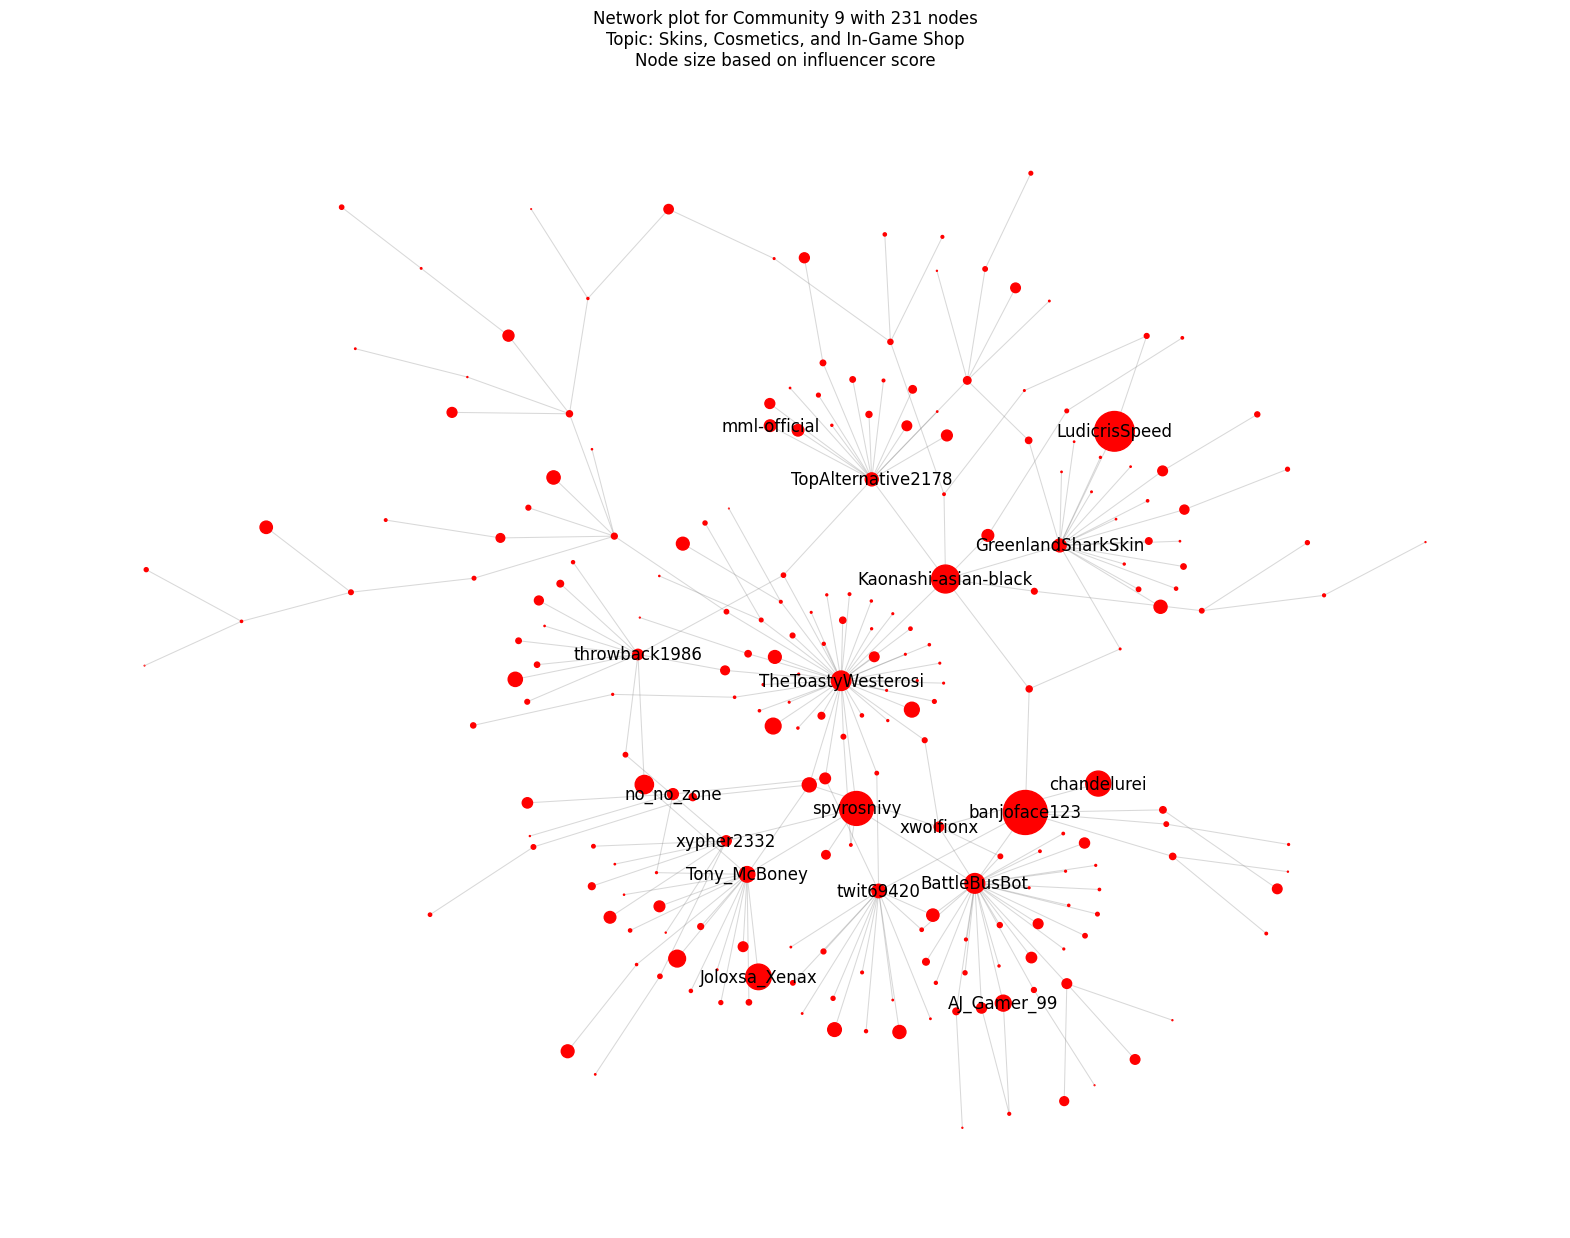

Average clustering coefficient: 0.3674329501915709

In [45]:
SELECTED_COMMUNITY_IDX = 9
G_community = plot_community_graph(G_filtered, communities, community_lens, SELECTED_COMMUNITY_IDX, SELECTED_TOPIC)

In [46]:
G_community_df = get_community_dataframe(G_community)

G_community_df

,author,average_score,num_comments,degree_centrality,betweenness_centrality,eigenvector_centrality,influencer_score,community
111,TheToastyWesterosi,1.750000,4,0.005501,0.001241,0.014589,0.034331,9
42,BattleBusBot,1.000000,4,0.004456,0.000827,0.016464,0.035001,9
220,banjoface123,7.310757,251,0.003903,0.002165,0.025604,0.175127,9
128,spyrosnivy,5.566265,249,0.002612,0.000883,0.015332,0.103954,9
120,twit69420,1.000000,3,0.002213,0.000270,0.009302,0.016337,9
...,...,...,...,...,...,...,...,...
25,lukeyy2322,1.750000,4,0.000031,0.000000,0.000244,0.000443,9
123,Ninjafarm67,1.250000,4,0.000031,0.000000,0.000216,0.000398,9
46,DoktorSanne,1.000000,3,0.000031,0.000000,0.000094,0.000173,9
75,Bansimulator,2.000000,2,0.000031,0.000000,0.000216,0.000272,9


### Posts and comments frequency

In [52]:
# Number of posts
num_posts_t = S_t.groupby("author").agg(num_posts=("id", "nunique"))

# Number of posts commented on
num_posts_commented_on_t = C_t.groupby("author").agg(
    num_posts_commented_on=("submission_id", "nunique")
)

author_metrics_t = (
    (
        G_community_df.set_index("author")
        .merge(num_posts_t, left_index=True, right_index=True, how="left")
        .merge(num_posts_commented_on_t, left_index=True, right_index=True, how="left")
    )
    .sort_values(by="influencer_score", ascending=False)
    .fillna(0)
    .reset_index()
)

author_metrics_t


,author,average_score,num_comments,degree_centrality,betweenness_centrality,eigenvector_centrality,influencer_score,community,num_posts,num_posts_commented_on
0,banjoface123,7.310757,251,0.003903,0.002165,2.560377e-02,0.175127,9,3.0,241
1,LudicrisSpeed,5.020000,150,0.001721,0.002191,2.445245e-02,0.142312,9,0.0,104
2,spyrosnivy,5.566265,249,0.002612,0.000883,1.533229e-02,0.103954,9,3.0,170
3,Kaonashi-asian-black,2.159509,163,0.001752,0.000621,1.142974e-02,0.070391,9,0.0,117
4,Joloxsa_Xenax,3.062500,48,0.000707,0.000267,1.420327e-02,0.059068,9,0.0,39
...,...,...,...,...,...,...,...,...,...,...
226,Avarage_Czech,1.666667,3,0.000031,0.000000,1.888060e-05,0.000069,9,1.0,1
227,tufachi,1.000000,2,0.000031,0.000000,1.803635e-05,0.000054,9,0.0,2
228,timeshifter747,1.333333,3,0.000031,0.000000,8.358591e-07,0.000044,9,1.0,1
229,Alyxstudios,1.000000,2,0.000031,0.000000,6.400981e-06,0.000041,9,0.0,1
